# Solenoid design

In [1]:
import numpy as np

u0 = 4.0 * np.pi * 1e-7
rho_wire = 1.72e-8 # Ohm m

def get_l_wire(N_turns, r_sol, l_wire_out):
    l_wire_sol = N_turns * 2.0 * np.pi * r_sol
    l_wire = l_wire_sol + 2.0 * l_wire_out
    return l_wire

def get_R_wire(l_wire, A_wire, rho_wire):
    R_wire = rho_wire * l_wire / A_wire
    return R_wire

def get_I(V, R_out, R_wire):
    I = V / (R_out + R_wire)
    return I

def get_B_sol(u_sol, N_turn, I, l_sol):
    B_sol = u0 * u_sol * N_turn * I / l_sol
    return B_sol

def get_m_sol(u_sol, N_turn, I, l_sol):
    m_sol = u_sol * N_turn * I * (np.pi * r_sol**2.0) 
    return m_sol

def get_L_sol(u_sol, N_turn, l_sol, r_sol):
    L_sol = u0 * u_sol * N_turn**2.0 / l_sol * (np.pi * r_sol**2.0) 
    return L_sol

def get_f_cutoff(L, R_wire, R_out):
    R = R_wire + R_out
    tau_cutoff = L/R
    f_cutoff = 1.0 / (2 * np.pi * tau_cutoff)
    return f_cutoff

In [27]:
# MTQ
r_sol = 34.0e-3 # m
l_sol = 920.0e-3 # m
u_sol = 60.0
V = 34.0
N_turn = 4900

l_wire_out = 0.0 # m ... One-way length of the wire out from the solenoid.
R_out = 0.0 # Ohm ... additional resistance
A_wire_MTQ =  7e-7 # only to match with R = 25 Ohm

l_wire_MTQ = get_l_wire(N_turn, r_sol, l_wire_out)
R_wire_MTQ = get_R_wire(l_wire_MTQ, A_wire_MTQ, rho_wire)
I_MTQ = get_I(V, R_out, R_wire_MTQ)
m_sol_MTQ = get_m_sol(u_sol, N_turn, I_MTQ, l_sol)
B_sol_MTQ = get_B_sol(u_sol, N_turn, I_MTQ, l_sol)
L_MTQ = get_L_sol(u_sol, N_turn, l_sol, r_sol)
f_cutoff_MTQ = get_f_cutoff(L_MTQ, R_wire_MTQ, R_out)
print("Num of turns:\t{:d}".format(N_turn))
print("Wire cross-section:\t{:.2e} mm^2".format(A_wire*1e6))
print("Out res:\t{:.2f} Ohm".format(R_out))
print("Voltage:\t{:.2f} V".format(V))
print("Wire len:\t{:.2f} m".format(l_wire_MTQ))
print("Wire res:\t{:.2f} Ohm".format(R_wire_MTQ))
print("Current:\t{:.2f} A".format(I_MTQ))
print("Mag field:\t{:.2f} T".format(B_sol_MTQ))
print("Reactance:\t{:.2f} H".format(L_MTQ))
print("Cutoff freq:\t{:.2f} Hz".format(f_cutoff_MTQ))

Num of turns:	4900
Wire cross-section:	1.00e+00 mm^2
Out res:	0.00 Ohm
Voltage:	34.00 V
Wire len:	1046.78 m
Wire res:	25.72 Ohm
Current:	1.32 A
Mag field:	0.53 T
Reactance:	7.15 H
Cutoff freq:	0.57 Hz


In [28]:
# Solenoid
r_sol = 10.0e-3 # m
l_sol = 100.0e-3 # m
#u_sol = 60000  # https://www.ohtama.co.jp/faq.html
u_sol = 60.0 # https://keisan.casio.jp/exec/user/1517118154

A_wire = 1.0e-6 # m^2 Select arbiterary.
l_wire_out = 2.0 # m ... One-way length of the wire out from the solenoid.
R_out = 0.0 # Ohm ... additional resistance
V_max = 3.4
N_turn_max = 3000

In [29]:
Vs = np.linspace(0, 1, 101) * V_max
N_turns = np.linspace(0, 1, 101) * N_turn_max

l_wires = [get_l_wire(N_turn, r_sol, l_wire_out) for N_turn in N_turns]
R_wires = [get_R_wire(l_wire, A_wire, rho_wire) for l_wire in l_wires]
Ls = [get_L_sol(u_sol, N_turn, l_sol, r_sol) for N_turn in N_turns]

Is=[]
B_sols=[]
f_cutoffs=[]
for N_turn in N_turns:
    l_wire = get_l_wire(N_turn, r_sol, l_wire_out)
    R_wire = get_R_wire(l_wire, A_wire, rho_wire)
    L = get_L_sol(u_sol, N_turn, l_sol, r_sol)
    f_cutoff = get_f_cutoff(L, R_wire, R_out)
    f_cutoffs.append(f_cutoff)
    for V in Vs:
        I = get_I(V, R_out, R_wire)
        B_sol = get_B_sol(u_sol, N_turn, I, l_sol)
        Is.append(I)
        B_sols.append(B_sol)
Is = np.array(Is).reshape(len(N_turns), len(Vs))
B_sols = np.array(B_sols).reshape(len(N_turns), len(Vs))

/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning:

divide by zero encountered in double_scalars



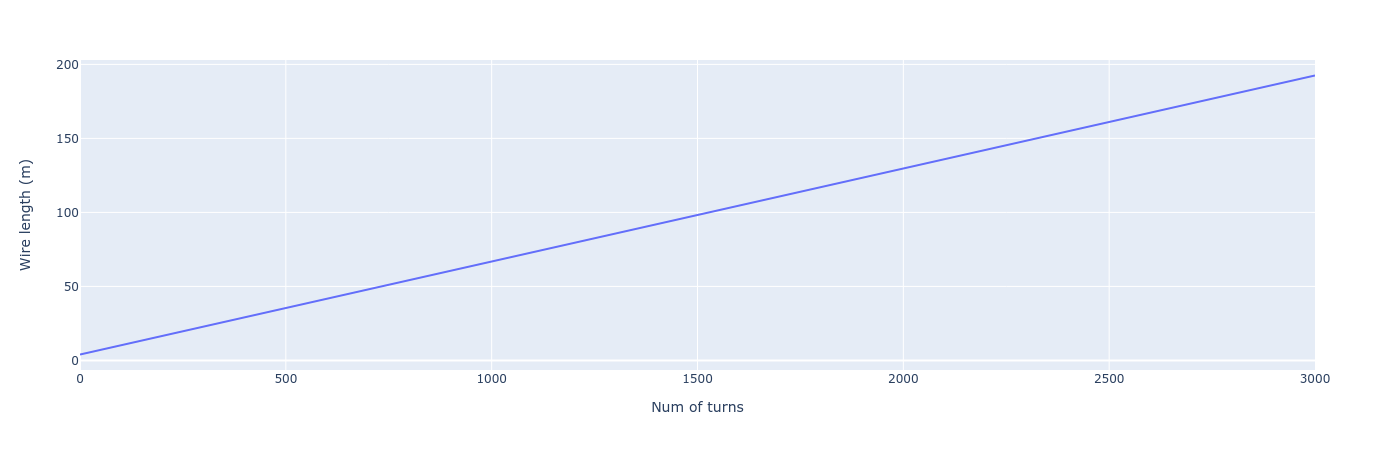

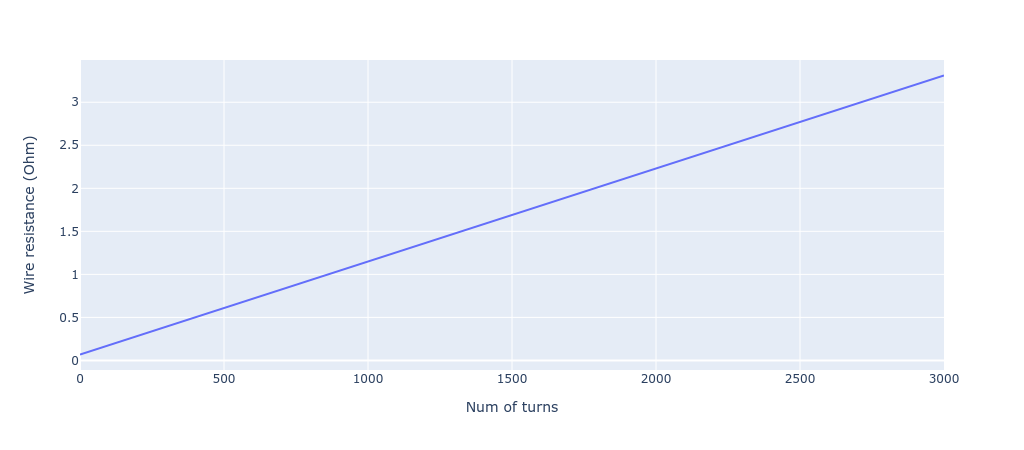

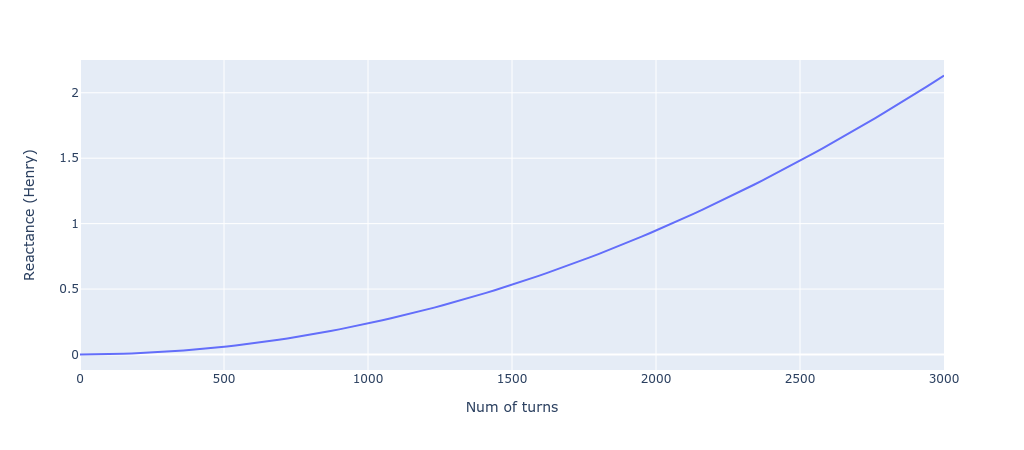

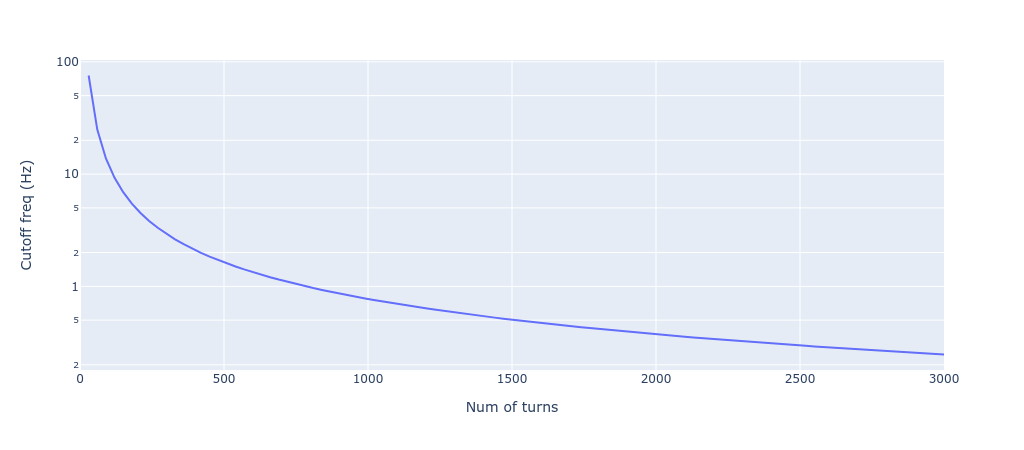

In [30]:
import plotly.express as px
fig = px.line(x=N_turns, y=l_wires, labels={'x':'Num of turns', 'y':'Wire length (m)'})
fig.show()
fig = px.line(x=N_turns, y=R_wires, labels={'x':'Num of turns', 'y':'Wire resistance (Ohm)'})
fig.show()
fig = px.line(x=N_turns, y=Ls, labels={'x':'Num of turns', 'y':'Reactance (Henry)'})
fig.show()
fig = px.line(x=N_turns, y=f_cutoffs, log_y=True, labels={'x':'Num of turns', 'y':'Cutoff freq (Hz)'})
fig.show()

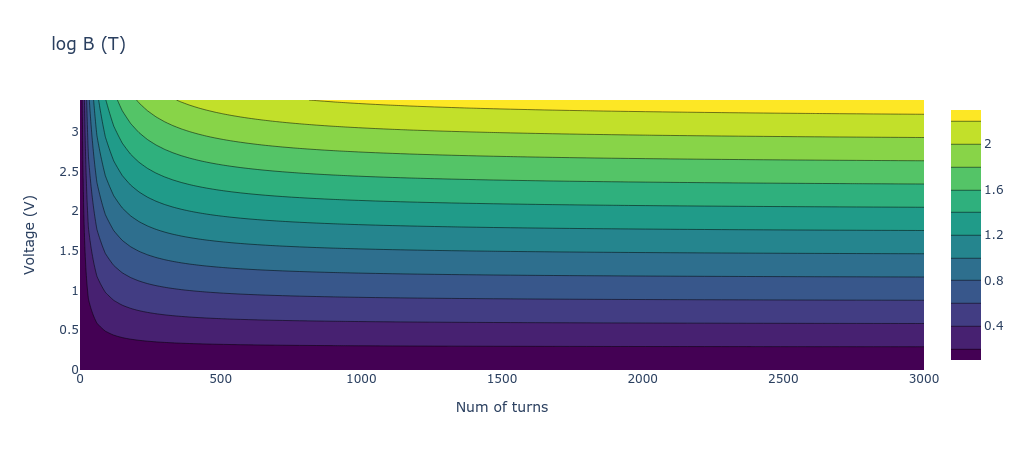

In [31]:
import plotly.graph_objects as go
fig = go.Figure(
        data=go.Contour(
            z=B_sols.T,
            y=Vs,
            x=N_turns,
            colorscale='Viridis'
            )
        )
    
fig.update_layout(
    title='log B (T)',
    yaxis_title_text='Voltage (V)',
    xaxis_title_text='Num of turns',
    )

fig.show()

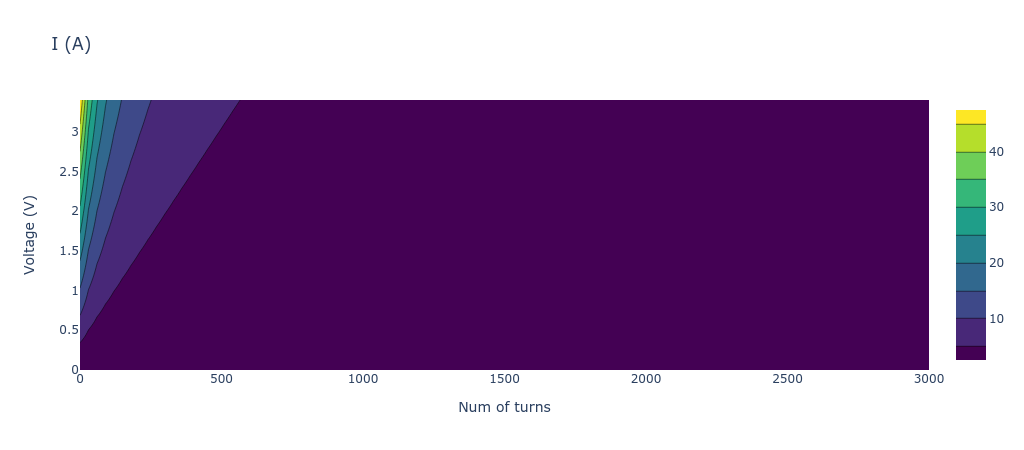

In [32]:
import plotly.graph_objects as go
fig = go.Figure(
        data=go.Contour(
            z=Is.T,
            y=Vs,
            x=N_turns,
            colorscale='Viridis'
            )
        )
    
fig.update_layout(
    title='I (A)',
    yaxis_title_text='Voltage (V)',
    xaxis_title_text='Num of turns',
    )

fig.show()

/usr/local/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning:

divide by zero encountered in true_divide



0.5728385675542906

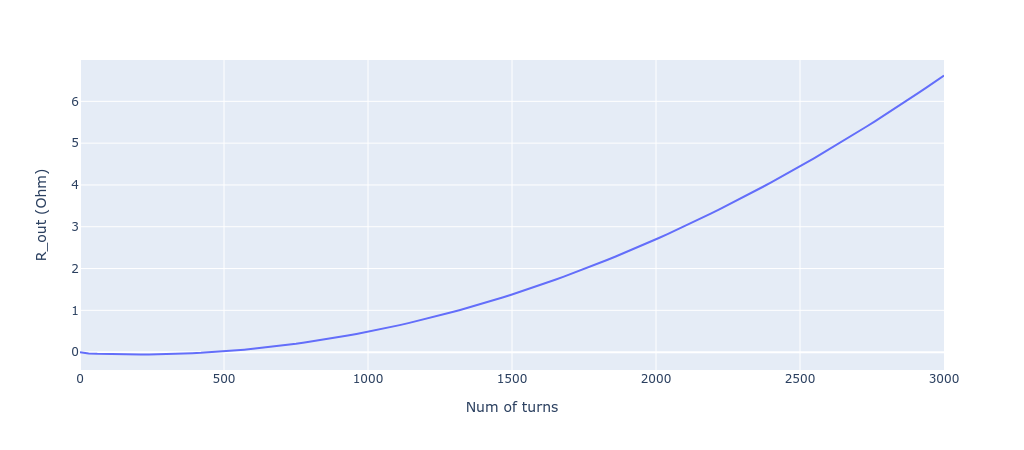

In [44]:
# Derive R_out against N_turn for a fixed f_cutoff_MTQ
from scipy import optimize

A_wire = 3.14e-6 # m^2 Select arbiterary.
def get_R_out(N_turn, f_cutoff_MTQ):
    l_wire = get_l_wire(N_turn, r_sol, l_wire_out)
    R_wire = get_R_wire(l_wire, A_wire, rho_wire)
    L = get_L_sol(u_sol, N_turn, l_sol, r_sol)    
    def get_f_cutoff_solution(R_out):
        return get_f_cutoff(L, R_wire, R_out) - f_cutoff_MTQ    
    solutions = optimize.fsolve(get_f_cutoff_solution, 0) #0近辺から解を探索
    assert len(solutions) == 1
    return solutions[0]

R_outs=[]
for N_turn in N_turns:
    R_out = get_R_out(N_turn, f_cutoff_MTQ)
    R_outs.append(R_out)

#
display(f_cutoff_MTQ)
fig = px.line(x=N_turns, y=R_outs, labels={'x':'Num of turns', 'y':'R_out (Ohm)'})
fig.show()

In [46]:
# A solenoid solution
N_turn = 450
R_out = 0
V = 1
l_wire = get_l_wire(N_turn, r_sol, l_wire_out)
R_wire = get_R_wire(l_wire, A_wire, rho_wire)
I = get_I(V, R_out, R_wire)
m_sol = get_m_sol(u_sol, N_turn, I, l_sol)
B_sol = get_B_sol(u_sol, N_turn, I, l_sol)
L = get_L_sol(u_sol, N_turn, l_sol, r_sol)
f_cutoff = get_f_cutoff(L, R_wire, R_out)
N_wrap = N_turn * 2.0*np.sqrt(A_wire/np.pi) / l_sol

print("Num of turns:\t{:d}".format(N_turn))
print("Wire cross-section:\t{:.2e} mm^2".format(A_wire*1e6))
print("Out res:\t{:.2f} Ohm".format(R_out))
print("Voltage:\t{:.2f} V".format(V))
print("Wire len:\t{:.2f} m".format(l_wire))
print("Wire res:\t{:.2f} Ohm".format(R_wire))
print("Current:\t{:.2f} A".format(I))
print("Mag field:\t{:.2f} T".format(B_sol))
print("Reactance:\t{:.2f} H".format(L))
print("Cutoff freq:\t{:.2f} Hz".format(f_cutoff))
print("Num of wraps:\t{:.2f}".format(N_wrap))
print(N_wrap*np.sqrt(A_wire/np.pi))

Num of turns:	450
Wire cross-section:	3.14e+00 mm^2
Out res:	0.00 Ohm
Voltage:	1.00 V
Wire len:	32.27 m
Wire res:	0.18 Ohm
Current:	5.66 A
Mag field:	1.92 T
Reactance:	0.05 H
Cutoff freq:	0.59 Hz
Num of wraps:	9.00
0.008995437383553923
